# Convolution Neural Network with Trained Word2Vec Embeddings for Part-Of-Speech Tagging - English

________________________________________
## Create the Dataset

In [37]:
import nltk
# Natural Language Toolkit's Brown, Treebank, and Conll2000 Corpora with universal tagset
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/bcd3q/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to /home/bcd3q/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/bcd3q/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/bcd3q/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [38]:
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')

# Combine the corpora into a single dataset
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [39]:
# Split data into lists of sentences and tags

X = []
Y = []

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for pair in sentence: 
        X_sentence.append(pair[0]) # the word
        Y_sentence.append(pair[1]) # the tag
    X.append(X_sentence)
    Y.append(Y_sentence)

In [40]:
# Look at the data
print("First Sentence:\n")
print(X[0])
print("\nIt's Tags:\n")
print(Y[0])

First Sentence:

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']

It's Tags:

['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']


#### Some information about the data:

In [41]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
tags = set([word.lower() for sentence in Y for word in sentence])
num_tags = len(tags)

In [42]:
print(num_words)
print(num_tags)
print(tags)

59448
12
{'adp', 'noun', 'x', 'adv', 'pron', '.', 'det', 'prt', 'conj', 'verb', 'adj', 'num'}


#### Tags: Conjunction, Punctuation, Numeral, Adverb, Verb, Noun, Pronoun, Adjective, Participle, Determiner, X(Other), Adposition

In [43]:
tagdict = {
    "conj": "Conjunction",
    ".": "Punctuation",
    "propn": "Proper Noun",
    "num": "Numeral",
    "adv": "Adverb",
    "verb": "Verb",
    "noun": "Noun",
    "pron": "Pronoun",
    "adj": "Adjective",
    "part": "Participle",
    "det": "Determiner",
    "x": "Other",
    "adp": "Adposition",
}

______________________________
## Prepare the Data

In [44]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

#### Tokenize and pad each sentence and it's tags:

In [45]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(X)            # fit tokeniser on data

# use the tokenizer to encode input sentence sequence
X_encoded = word_tokenizer.texts_to_sequences(X)  

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)

# use the tokenizer to encode input tag sequence
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [72]:
# save the tokenizers for use in our demo
import io
import json
wtokenizer_json = word_tokenizer.to_json()
ttokenizer_json = tag_tokenizer.to_json()
with io.open('wtokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(wtokenizer_json, ensure_ascii=False))
with io.open('ttokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(ttokenizer_json, ensure_ascii=False))

In [46]:
# sequences greater than 50 in length will be truncated
MAX_SEQ_LENGTH = 50
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

#### Split Data into Training and Testing Data

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_padded, test_size=0.15, random_state=4)

#### Create an Embedding Matrix using Word2Vec:

In [12]:
import gensim.downloader
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

[================================================--] 97.6% 1623.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [48]:
from gensim.models import KeyedVectors

# word2vec
path = "gensim-data1/word2vec-google-news-300/word2vec-google-news-300.gz"

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

# assign word vectors from word2vec model
# each word in word2vec model is represented using a 300 dimensional vector
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

#### One-hot encode Y:

In [49]:
# use Keras' to_categorical function to one-hot encode Y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

#### Data Shapes:

In [50]:
print("Training shapes:\n")
print(X_train.shape)
print(Y_train.shape)
print("\nTesting Shapes:\n")
print(X_test.shape)
print(Y_test.shape)

Training shapes:

(61371, 50)
(61371, 50, 13)

Testing Shapes:

(10831, 50)
(10831, 50, 13)


___________________________
## Build the Model

In [51]:
from keras.models import Model
from keras.models import Sequential
from keras import layers
from tensorflow.keras import backend as K

#### Function to ignore the accuracy of paddings:
##### From: https://nlpforhackers.io/lstm-pos-tagger-keras/ 

In [59]:
def accuracy_masked(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)

    ignore_mask = K.cast(K.not_equal(y_true_class, 0), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy

#### Sequential Convolution Network:

In [63]:
model = Sequential()
model.add(layers.Embedding(input_dim   = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
model.add(layers.Conv1D(128, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=1, strides=1, padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(13, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy(), accuracy_masked])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           17834700  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 128)           76928     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 50, 128)           16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 50, 128)          

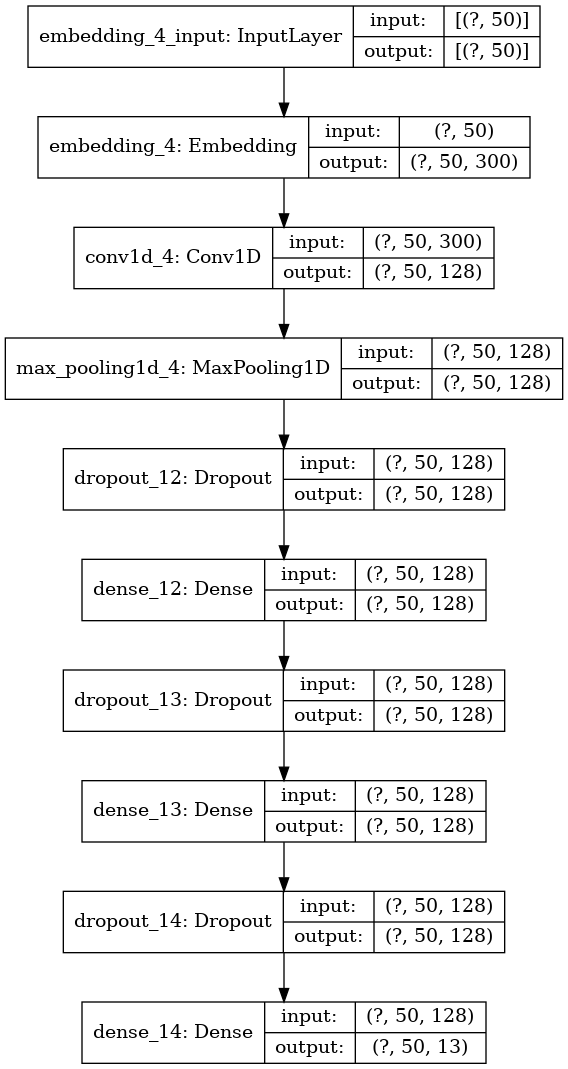

In [64]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

__________________________
## Train the Model

In [65]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_split = 0.2,
                    batch_size=128)

Epoch 1/10
384/384 [==============================] - 118s 308ms/step - loss: 0.2872 - categorical_accuracy: 0.9258 - accuracy_masked: 0.8366 - val_loss: 0.0528 - val_categorical_accuracy: 0.9833 - val_accuracy_masked: 0.9598
Epoch 2/10
384/384 [==============================] - 117s 305ms/step - loss: 0.0534 - categorical_accuracy: 0.9843 - accuracy_masked: 0.9623 - val_loss: 0.0485 - val_categorical_accuracy: 0.9846 - val_accuracy_masked: 0.9628
Epoch 3/10
384/384 [==============================] - 118s 307ms/step - loss: 0.0419 - categorical_accuracy: 0.9872 - accuracy_masked: 0.9692 - val_loss: 0.0475 - val_categorical_accuracy: 0.9851 - val_accuracy_masked: 0.9642
Epoch 4/10
384/384 [==============================] - 117s 304ms/step - loss: 0.0368 - categorical_accuracy: 0.9885 - accuracy_masked: 0.9724 - val_loss: 0.0481 - val_categorical_accuracy: 0.9851 - val_accuracy_masked: 0.9641
Epoch 5/10
384/384 [==============================] - 118s 307ms/step - loss: 0.0336 - categoric

In [66]:
tf.keras.models.save_model(
    model, "englishModel", overwrite=True, include_optimizer=True, save_format='tf',
    signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: englishModel/assets


_____________________________
## Results:

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# Evaluate the final performance of the network
score = model.evaluate(X_test,Y_test,verbose=1)
print("Loss:",score[0])
print("Accuracy:",score[1])
print("Masked Accuracy: ", score[2])

339/339 [==============================] - 3s 8ms/step - loss: 0.0630 - categorical_accuracy: 0.9857 - accuracy_masked: 0.9654
Loss: 0.06298849731683731
Accuracy: 0.9856929183006287
Masked Accuracy:  0.9653927683830261


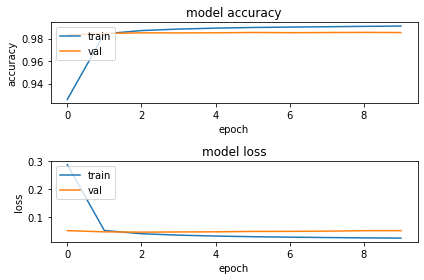

In [73]:
plt.figure(1) 

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show() 

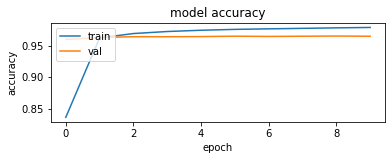

In [74]:
plt.figure(1) 

# summarize history for masked accuracy

plt.subplot(211)
plt.plot(history.history['accuracy_masked'])
plt.plot(history.history['val_accuracy_masked'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

_____________________________________________
## Demo

In [76]:
from nltk.tokenize import word_tokenize

def output_prediction(text):
    # Pre-process data like we did for training.
    text = [word_tokenize(text)]
    text_encoded = word_tokenizer.texts_to_sequences(text) 
    text_padded = pad_sequences(text_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
    
    # Make a prediction
    ynew = np.argmax(model.predict(text_padded), axis=-1)
    prediction = ynew[0]
    
    # Trim leading zeros
    prediction = np.trim_zeros(prediction)
        
    # Decode prediction
    decoded = tag_tokenizer.sequences_to_texts([prediction])
    decoded = word_tokenize(decoded[0])
    decoded = [tagdict[tag] for tag in decoded]
    
    # show the inputs and predicted outputs
    print("      Sentence= %s\nPredicted Tags= %s" % (text, decoded))

# Type your own sentence in place of the one below!
text = "The red cat took a very long walk along the winding river."
output_prediction(text)

      Sentence= [['The', 'red', 'cat', 'took', 'a', 'very', 'long', 'walk', 'along', 'the', 'winding', 'river', '.']]
Predicted Tags= ['Determiner', 'Adjective', 'Noun', 'Verb', 'Determiner', 'Adverb', 'Adjective', 'Verb', 'Adposition', 'Determiner', 'Verb', 'Noun', 'Punctuation']


__________________________________________________________________
Data Pre-Processing Inspired By: https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849,
https://www.nltk.org/nltk_data/,
https://www.nltk.org/
Model Inspired By: https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c
Masked Accuracy Class Inspired By: https://nlpforhackers.io/lstm-pos-tagger-keras/
Word Embeddings: https://www.tensorflow.org/tutorials/text/word2vec